# Calculate RRs for diarrhea exposure and wasting outcome from continuous shift

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #makes the display bars longer and spread out 100% across the screen width

In [2]:
from db_queries import get_outputs as go

In [3]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from scipy import stats
import math

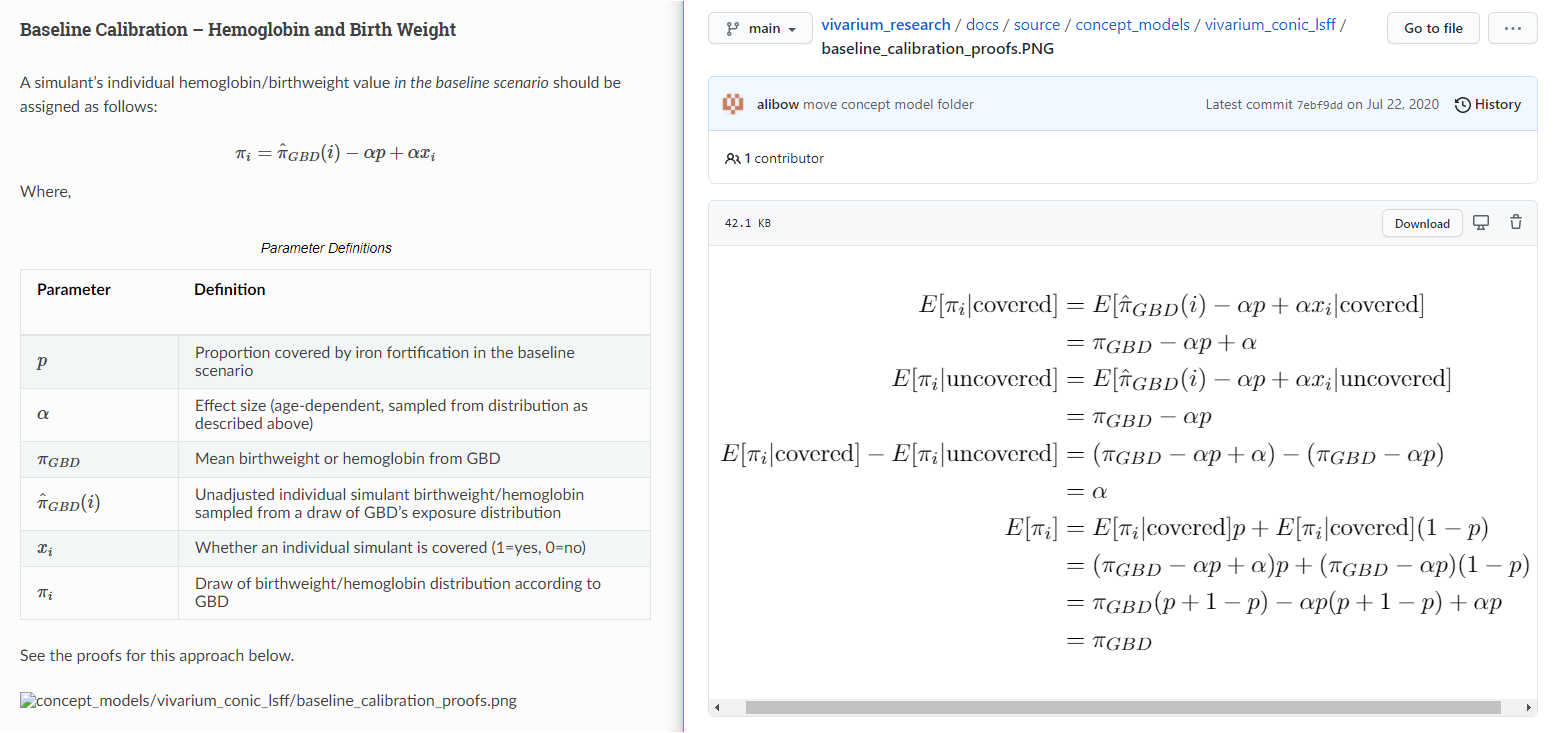

# Artifact data for diarrhea prevalence

In [4]:
#loading artifact 

art = Artifact('/ihme/costeffectiveness/artifacts/vivarium_ciff_sam/ethiopia.hdf', filter_terms=['year_start == 2019', 'age_start >=  0.076712', f'age_end <= 5'])


/share/code/beatrixh/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()


In [5]:
#load population structure

art_pop = art.load('population.structure').reset_index()
art_pop

,location,sex,age_start,age_end,year_start,year_end,value
0,Ethiopia,Female,0.076712,1.0,2019,2020,1.573806e+06
1,Ethiopia,Female,1.000000,5.0,2019,2020,6.437387e+06
2,Ethiopia,Male,0.076712,1.0,2019,2020,1.651227e+06
3,Ethiopia,Male,1.000000,5.0,2019,2020,6.742224e+06


In [6]:
#load keys

art.keys

['metadata.keyspace',
 'metadata.locations',
 'population.location',
 'population.structure',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'cause.all_causes.cause_specific_mortality_rate',
 'cause.diarrheal_diseases.prevalence',
 'cause.diarrheal_diseases.incidence_rate',
 'cause.diarrheal_diseases.remission_rate',
 'cause.diarrheal_diseases.disability_weight',
 'cause.diarrheal_diseases.excess_mortality_rate',
 'cause.diarrheal_diseases.cause_specific_mortality_rate',
 'cause.diarrheal_diseases.restrictions',
 'cause.measles.prevalence',
 'cause.measles.incidence_rate',
 'cause.measles.disability_weight',
 'cause.measles.excess_mortality_rate',
 'cause.measles.cause_specific_mortality_rate',
 'cause.measles.restrictions',
 'cause.lower_respiratory_infections.prevalence',
 'cause.lower_respiratory_infections.incidence_rate',
 'cause.lower_respiratory_infections.remission_rate',
 'cause.lower_respiratory_infections.disability_weight',
 '

In [7]:
#here I make sex ratio in order to weigh the diarrhea prevalence by sex to get a non-sex specific prevalence by age (aka collapsed over sex)

locations = ['ethiopia']

def load_artifact_sr(age_end):
    age_end = float(age_end)
    tab = pd.DataFrame()
    for i in locations:
        art = Artifact('/ihme/costeffectiveness/artifacts/vivarium_ciff_sam/' + i + '.hdf', filter_terms=['year_start == 2017', 'age_start >=  0.076712', f'age_end = {age_end}'])  #'draw == 0', 
        #print(i)
        sr = art.load('population.structure').reset_index()
        sr = sr.rename(columns={'value':'pop'})
        sr['total_pop'] = sr['pop'][0] + sr['pop'][1]
        sr['sex_ratio'] = sr['pop'] / sr['total_pop']
        tab=tab.append(sr)      
        
    return tab

In [8]:
#input to function is age_end (age_start always 28days)
# this is for 28days to 1 year age groups

sex_ratio_1y = load_artifact_sr(1).reset_index()
sex_ratio_1y

/share/code/beatrixh/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()


,index,location,sex,age_start,age_end,year_start,year_end,pop,total_pop,sex_ratio
0,0,Ethiopia,Female,0.076712,1.0,2017,2018,1.527094e+06,3.128825e+06,0.488073
1,1,Ethiopia,Male,0.076712,1.0,2017,2018,1.601731e+06,3.128825e+06,0.511927


In [9]:
# this is for 1 year to 5 years age group

sex_ratio_1y = load_artifact_sr(5).reset_index()
sex_ratio_1y

/share/code/beatrixh/miniconda/envs/vivarium_ciff_sam/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()


,index,location,sex,age_start,age_end,year_start,year_end,pop,total_pop,sex_ratio
0,0,Ethiopia,Female,1.0,5.0,2017,2018,6.283283e+06,1.286057e+07,0.48857
1,1,Ethiopia,Male,1.0,5.0,2017,2018,6.577288e+06,1.286057e+07,0.51143


In [10]:
art_ddprev = art.load('cause.diarrheal_diseases.prevalence').reset_index()
art_ddprev

# average over sex for each age group with appropriate sex ratio 
# Need to get the sex-weighted prevalence of diarrhea - to be honest, this is not going to make a HUGE difference, but since it's not too difficult to do, we can just do it. 

,sex,age_start,age_end,year_start,year_end,draw_0,draw_1,draw_2,draw_3,draw_4,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,Female,0.076712,1.0,2019,2020,0.044737,0.045736,0.050546,0.049880,0.045254,...,0.050668,0.037926,0.040442,0.045302,0.045454,0.049403,0.049524,0.039955,0.041216,0.050064
1,Female,1.000000,5.0,2019,2020,0.021527,0.024015,0.027886,0.026758,0.028586,...,0.030333,0.019154,0.030310,0.027931,0.022661,0.023849,0.037431,0.023988,0.021482,0.024692
2,Male,0.076712,1.0,2019,2020,0.044790,0.046587,0.049791,0.050248,0.044858,...,0.050115,0.037692,0.039436,0.043721,0.045185,0.050263,0.049663,0.038012,0.039818,0.049492
3,Male,1.000000,5.0,2019,2020,0.022138,0.024811,0.028130,0.026658,0.029375,...,0.030801,0.019875,0.028346,0.027962,0.022256,0.024650,0.036138,0.021885,0.021131,0.025147


In [11]:
# GET a sex weighted prevalence by age groups
# this will be the age-specific p in the formula

dd_prev = go(
    "cause",
    cause_id = [302], 
    metric_id = 2, 
    sex_id = 3,
    measure_id = 5, 
    age_group_id = [4,5],
    gbd_round_id = 6, 
    decomp_step = 'step5'
)

dd_prev = dd_prev[['age_group_id','val','upper','lower']]

# # do i need to convert from percent to prop?
# dd_prev.val = dd_prev.val / 100 
# dd_prev.upper = dd_prev.upper / 100 
# dd_prev.lower = dd_prev.lower / 100 

dd_prev

,age_group_id,val,upper,lower
0,4,0.044629,0.050800,0.039049
1,5,0.023016,0.028849,0.018269


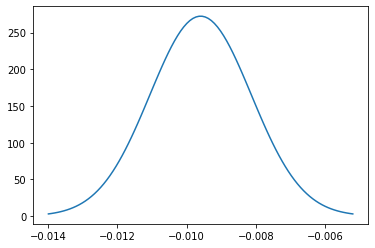

In [12]:
# Alpha is weight-for-height Z-score (–0·0096 [–0·0067 to –0·0125]) shift

alpha = -0.0096
sigma = (0.0125 - 0.0067)/(2*1.98)

x = np.linspace(alpha - 3*sigma, alpha + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, alpha, sigma))
plt.show()



In [13]:
whz_scores_path = '/snfs1/Project/simulation_science/ciff_malnutrition/Data/cgf_data/whz_scores_age_raked.csv'
scores = pd.read_csv(whz_scores_path)

In [14]:
scores

,xpoints,pdf_points,cdf_points,age_group_id,age_start,age_end,location_name,sex_id,year_id
0,-7.000000,0.000000e+00,0.000000e+00,4,0.076712,1.0,Ethiopia,3,2019
1,-7.000000,0.000000e+00,0.000000e+00,5,1.000000,5.0,Ethiopia,3,2019
2,-6.997199,7.897610e-08,1.105887e-10,4,0.076712,1.0,Ethiopia,3,2019
3,-6.997199,6.563434e-06,9.190646e-09,5,1.000000,5.0,Ethiopia,3,2019
4,-6.994399,7.970347e-08,3.327845e-10,4,0.076712,1.0,Ethiopia,3,2019
...,...,...,...,...,...,...,...,...,...
9995,6.994399,5.408687e-04,9.994148e-01,5,1.000000,5.0,Ethiopia,3,2019
9996,6.997199,1.165869e-02,9.888329e-01,4,0.076712,1.0,Ethiopia,3,2019
9997,6.997199,5.393632e-04,9.994163e-01,5,1.000000,5.0,Ethiopia,3,2019
9998,7.000000,0.000000e+00,9.888655e-01,4,0.076712,1.0,Ethiopia,3,2019


In [15]:
# is this a mathematically sound thing to do with the pdf?
def sample_whz_score(age_group, N):
    #for each x value, get pdf(x)
    x, pdf_x = scores[scores.age_group_id==age_group].xpoints, scores[scores.age_group_id==age_group].pdf_points
    
    # use random.choice, giving normalized pdf(x) val
    whz = np.random.choice(a = x, p = pdf_x / sum(pdf_x), size = N)
    return pd.Series(whz)

In [16]:
# along x axis, plot z scores
# along y axis, plot CDF and "sampled"/empirical CDF

In [17]:
?plt.hist

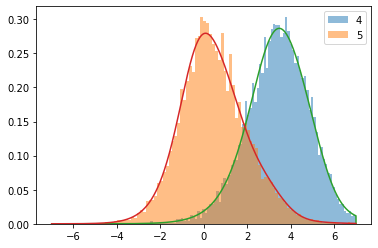

In [18]:
#check out z score distributions
for age in [4,5]:
    plt.hist(sample_whz_score(age, 10_000), bins = 100, alpha = 0.5, label = age, density = True)
for start, df_t in scores.groupby('age_start'):
    plt.plot(df_t.xpoints, df_t.pdf_points)
plt.legend()
plt.show()

In [19]:
def assign_exposure_stratified_whz(exposed, effect_size, prev, age_group):
    """
    INPUTS
    ----
    exposed: pd.Series() vector of exposure values (1==exposed, 0==unexposed)
    effect_size: effect size of dichotomous exposure (diarrhea) on whz score
    prev: prevalence of exposure (diarrhea)
    age_group: age_group_id of the population
    ----
    OUTPUTS
    ----
    pd.Series() of whz scores adjusted for exposure status (exposure == diarrhea)
    """
    assert(type(exposed)==pd.core.series.Series), "'exposed' must be a pd.Series()"
    
    N = len(exposed)
    unadjusted = sample_whz_score(age_group, N)
    return unadjusted - effect_size * prev + effect_size * exposed

In [20]:
#for each age strata I think this will give us the exposure distributions

def initialize_sims(n_sims, exp_prev, age_group, alpha):
    """
    INPUTS
    ----
    n_sims
    exp_prev: scalar prevalence (metric = prop) of exposure
    age_group: gbd age_group_id corresponding to exp_prev
    alpha: effect size of exposure for outcome
    ----
    OUTPUTS
    ----
    pd.DataFrame() of sims with id, age_group, exposure status (binary), and z score
    """
    # determine simulant exposure based on prevalence of exposure variable (diarrhea)
    prev = exp_prev.loc[(exp_prev.age_group_id==age_group)].iloc[0]['val']
    propensity = np.random.uniform(size=n_sims)
    exposed = pd.Series([1 if p <= prev else 0 for p in propensity])
    
    
    sims = pd.DataFrame({
        'id':range(1,n_sims+1),
        'age_group_id': age_group, #update this
        'exposure_propensity': propensity, #this is a random number for propensity- are you familiar with propensity? It is a random value between 0 to 1. If someone has propensity less than the prevalence of DD, then they have diarrhea. If their propensity is above DD, they don't have diarrhea
        'exposed_to_dd': exposed, #equals to 1 exposed if propensity is less than ddprev for that age and sex, and equals to 0 if propensity > ddprev
        'whz_i': assign_exposure_stratified_whz(exposed, alpha, prev, age_group) # this is where we need the formula to calculate the invididual z-scores with the formula based on the exposed_to_dd variable (1=exposed to dd; 0=unexposed to dd)
    })
                                          
    return sims

In [21]:
def map_wasting_categories(sims):
    """
    INPUTS
    ----
    sims: pd.DataFrame() of simulants with a column 'whz_i' of zscores
    ----
    OUTPUTS
    ----
    sims: pd.DataFrame() with wasting category corresponding to whz_i
    """
    conditions = [
        (sims['whz_i']  < -3),
        (sims['whz_i'] >= -3) & (sims['whz_i'] < -2),
        (sims['whz_i'] >= -2) & (sims['whz_i'] < -1),
        (sims['whz_i'] >= -1)]

    values = [1, 2, 3, 4]

    sims['cat'] = np.select(conditions, values)
    sims['cat'] = np.select(conditions, values)
    
    return sims

In [22]:
def tabulate_wasting_cat_by_exposure_status(n_sims, exp_prev, age_group, alpha):
    """
    INPUTS
    ----
    n_sims
    exp_prev: scalar prevalence (metric = prop) of exposure
    age_group: gbd age_group_id corresponding to exp_prev
    alpha: effect size of exposure for outcome
    ----
    OUTPUTS
    ----
    pd.DataFrame():
        columns = wasting categories
        rows = exposure status
        values = counts of sims
    """
    # initialize sims
    df = initialize_sims(n_sims, exp_prev, age_group, alpha)
    
    # assign wasting categories
    df = map_wasting_categories(df)
    
    # count categories by exposure status
    df = pd.DataFrame(df.groupby(['exposed_to_dd']).cat.value_counts()).rename(columns={'cat':'val'})
    
    # reformat
    df = df.reset_index().pivot(index = 'exposed_to_dd', columns = 'cat', values = 'val')
    df = df.rename(
        index = {0:'unexposed',1:'exposed'},
        columns = {1:'cat1',2:'cat2',3:'cat3',4:'TMREL'}
    )
    
    return df

In [23]:
n_sims = 10_000_000

In [24]:
sims_post_neonatal = tabulate_wasting_cat_by_exposure_status(n_sims, exp_prev = dd_prev, age_group = 4, alpha = alpha)
sims_1_4 = tabulate_wasting_cat_by_exposure_status(n_sims, exp_prev = dd_prev, age_group = 5, alpha = alpha)

In [25]:
sims_post_neonatal

cat,cat1,cat2,cat3,TMREL
exposed_to_dd,,,,
unexposed,2137,7721,29345,9514061
exposed,101,355,1346,444934


In [26]:
sims_1_4

cat,cat1,cat2,cat3,TMREL
exposed_to_dd,,,,
unexposed,92655,332094,1146613,8197638
exposed,2277,8163,27422,193138


In [36]:
def calc_rr(df):
    df_t = df.div(df.sum(axis=1), axis = 0)
    return df_t.iloc[1] / df_t.iloc[0]

In [38]:
calc_rr(sims_post_neonatal)

cat
cat1     1.010689
cat2     0.983231
cat3     0.980871
TMREL    1.000070
dtype: float64

In [37]:
calc_rr(sims_1_4)

cat
cat1     1.039279
cat2     1.039506
cat3     1.011394
TMREL    0.996362
dtype: float64

# 3. Get wasting category prevalences by exposure to dd: we need the proportion with the total population as denominator (eg. 100,000)
		
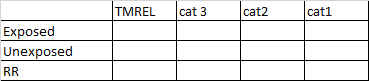